In [148]:
import pandas as pd
import numpy as np
import pprint


import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import utils

import os
import nibabel as nib
import copy

import matplotlib.pyplot as plt
%matplotlib inline

import random
import skimage.transform as skTrans
import cv2
from numpy import logical_and as l_and, logical_not as l_not
from scipy.spatial.distance import directed_hausdorff


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Data

In [3]:
image_dir = '../../MICCAI_BraTS2020_TrainingData/'
naming = pd.read_csv(f'../../MICCAI_BraTS2020_TrainingData/name_mapping.csv') # , index_col=0)
data_df = pd.DataFrame(naming['BraTS_2020_subject_ID'])
n_p = 50 # n_patients_to_train_with
train_df = data_df[:n_p]
valid_df = data_df[n_p:n_p*2]

In [5]:
channels = 4
resize_shape = (144,144,144)

# Transformations

In [4]:
class ScaleToFixed(object):

    def __init__(self, new_shape, interpolation=1, channels=4):
        self.shape= new_shape
        self.interpolation = interpolation
        self.channels = channels

    def __call__(self, image):
        # print('first shape', image.shape)
        if image is not None: # (some patients don't have segmentations)
            if self.channels == 1:
                short_shape = (self.shape[1], self.shape[2], self.shape[3])
                image = skTrans.resize(image, short_shape, order=self.interpolation, preserve_range=True)  #
                image = image.reshape(self.shape)
            else:
                image = skTrans.resize(image, self.shape, order=self.interpolation, preserve_range=True)  #

        # print('second shape', image.shape)
        # print()
        return image

class RandomFlip(object):
    """Randomly flips (horizontally as well as vertically) the given PIL.Image with a probability of 0.5
    """
    def __init__(self, prob_flip=0.5):
        self.prob_flip= prob_flip
    def __call__(self, image):

        if random.random() < self.prob_flip:
            flip_type = np.random.randint(0, 3) # flip across any 3D axis
            image = np.flip(image, flip_type)
        return image

class ZeroChannel(object):
    """Randomly sets channel to zero the given PIL.Image with a probability of 0.25
    """
    def __init__(self, prob_zero=0.25, channels=4):
        self.prob_zero= prob_zero
        self.channels = channels
    def __call__(self, image):

        if np.random.random() < self.prob_zero:
            channel_to_zero = np.random.randint(0, self.channels) # flip across any 3D axis
            zeros = np.zeros((image.shape[1], image.shape[2], image.shape[3]))
            image[channel_to_zero, :, :, :] = zeros
        return image

class ZeroSprinkle(object):
    def __init__(self, prob_zero=0.25, prob_true=0.5, channels=4):
        self.prob_zero=prob_zero
        self.prob_true=prob_true
        self.channels=channels
    def __call__(self, image):

        if self.prob_true:
            mask = np.random.rand(image.shape[0], image.shape[1], image.shape[2], image.shape[3])
            mask[mask < self.prob_zero] = 0
            mask[mask > 0] = 1
            image = image*mask

        return image


class MinMaxNormalize(object):
    """Min-Max normalization
    """
    def __call__(self, image):
        def norm(im):
            im = im.astype(np.float32)
            min_v = np.min(im)
            max_v = np.max(im)
            im = (im - min_v)/(max_v - min_v)
            return im
        image = norm(image)
        return image

class ToTensor(object):
    def __init__(self, scale=1):
        self.scale = scale

    def __call__(self, image):
        if image is not None:
            image = image.astype(np.float32)
            image = image.reshape((image.shape[0], int(image.shape[1]/self.scale), int(image.shape[2]/self.scale), int(image.shape[3]/self.scale)))
            image_tensor = torch.from_numpy(image)
            return image_tensor
        else:
            return image


class Compose(object):
    """
    Composes several transforms together.
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for i, t in enumerate(self.transforms):
            image = t(image)
        return image

In [6]:

# basic data augmentation
prob_voxel_zero = 0 # 0.1
prob_channel_zero = 0 # 0.5
prob_true = 0 # 0.8
randomflip = RandomFlip()

# MRI transformations
train_transformations = Compose([
    MinMaxNormalize(),
    ScaleToFixed((channels, resize_shape[0],resize_shape[1],resize_shape[2]),
                          interpolation=1,
                          channels=channels),
    ZeroSprinkle(prob_zero=prob_voxel_zero, prob_true=prob_true),
    ZeroChannel(prob_zero=prob_channel_zero),
    randomflip,
    ToTensor()
])

# GT segmentation mask transformations

seg_transformations = Compose([
            ScaleToFixed((1, resize_shape[0],resize_shape[1],resize_shape[2]),
                                      interpolation=0,
                                      channels=1),
            randomflip,
            ToTensor(),
        ])

# Dataloader

In [7]:
def get_bb_3D(img, pad=0):
    '''
    This function returns a tumor 3D bounding box using a segmentation mask
    '''
    xs = np.nonzero(np.sum(np.sum(img, axis=1), axis=1))
    ys = np.nonzero(np.sum(np.sum(img, axis=0), axis=1))
    zs = np.nonzero(np.sum(np.sum(img, axis=0), axis=0))
    xmin, xmax = np.min(xs), np.max(xs)
    ymin, ymax = np.min(ys), np.max(ys)
    zmin, zmax = np.min(zs), np.max(zs)
    bbox = (xmin-pad, ymin-pad, zmin-pad, xmax+pad, ymax+pad, zmax+pad)
    return bbox

def min_max(img):
    '''
    Min-max normalization
    '''
    return (img - img.min()) / (img.max() - img.min())

def read_mri(mr_path_dict, pad=0):

    image_shape = nib.load(mr_path_dict['flair']).get_fdata().shape
    bb_seg = get_bb_3D(nib.load(mr_path_dict['flair']).get_fdata())
    (xmin, ymin, zmin, xmax, ymax, zmax) = bb_seg

    xmin = np.max([0, xmin-pad])
    ymin = np.max([0, ymin-pad])
    zmin = np.max([0, zmin-pad])

    xmax = np.min([image_shape[0]-1, xmax+pad])
    ymax = np.min([image_shape[1]-1, ymax+pad])
    zmax = np.min([image_shape[2]-1, zmax+pad])


    img_dict = {}
    for key in ['flair', 't1', 't1ce', 't2', 'seg']:
        img = nib.load(mr_path_dict[key])
        img_data = img.get_fdata()
        img_dict[key] = img_data[xmin:xmax, ymin:ymax, zmin:zmax]

    stacked_img = np.stack([min_max(img_dict['flair']), min_max(img_dict['t1']),min_max(img_dict['t1ce']),min_max(img_dict['t2'])], axis=0)
    return stacked_img, img_dict['seg']


In [14]:
def plot_(image, seg, predicted=False):
    #Overlay with Predicted
    img = image[slice, :, :, :].squeeze()
    img = utils.make_grid(img)
    img = img.detach().cpu().numpy()
    
    print(img.shape)
    
    # plot images
    plt.figure(figsize=(10, 8))
    img_list = [img[i].T for i in range(channels)] # 1 image per channel
    plt.imshow(np.hstack(img_list), cmap='Greys_r')
    
    ## plot segmentation mask ##
    seg_img = torch.tensor(pred[slice].squeeze())
    if not predicted:
        seg_img = torch.tensor(seg_img.numpy()[:, ::-1].copy()) #flip
    seg_img = utils.make_grid(seg_img).detach().cpu().numpy()
    
    print(np.unique(seg_img))

    plt.imshow(np.hstack([seg_img[0].T]), cmap='Greys_r', alpha=0.3)
    plt.show()
    

In [126]:
def calculate_metrics(preds, targets, patient, tta=False):
    """
    Parameters
    ----------
    preds:
        torch tensor of size 1*C*Z*Y*X
    targets:
        torch tensor of same shape
    patient :
        The patient ID
    tta:
        is tta performed for this run
    """
    pp = pprint.PrettyPrinter(indent=4)
    assert preds.shape == targets.shape, "Preds and targets do not have the same size"

    labels = ["ET", "TC", "WT"]

    metrics_list = []

    for i, label in enumerate(labels):
        metrics = dict(
            patient_id=patient,
            label=label,
            tta=tta,
        )

        if np.sum(targets[i]) == 0:
            print(f"{label} not present for {patient}")
            sens = np.nan
            dice = 1 if np.sum(preds[i]) == 0 else 0
            tn = np.sum(l_and(l_not(preds[i]), l_not(targets[i])))
            fp = np.sum(l_and(preds[i], l_not(targets[i])))
            spec = tn / (tn + fp)
            haussdorf_dist = np.nan

        else:
            preds_coords = np.argwhere(preds[i])
            targets_coords = np.argwhere(targets[i])
            haussdorf_dist = directed_hausdorff(preds_coords, targets_coords)[0]

            tp = np.sum(l_and(preds[i], targets[i]))
            tn = np.sum(l_and(l_not(preds[i]), l_not(targets[i])))
            fp = np.sum(l_and(preds[i], l_not(targets[i])))
            fn = np.sum(l_and(l_not(preds[i]), targets[i]))

            sens = tp / (tp + fn)
            spec = tn / (tn + fp)

            dice = 2 * tp / (2 * tp + fp + fn)

        metrics[HAUSSDORF] = haussdorf_dist
        metrics[DICE] = dice
        metrics[SENS] = sens
        metrics[SPEC] = spec
        pp.pprint(metrics)
        metrics_list.append(metrics)

    return metrics_list


HAUSSDORF = "haussdorf"
DICE = "dice"
SENS = "sens"
SPEC = "spec"
METRICS = [HAUSSDORF, DICE, SENS, SPEC]


In [127]:
class GeneralDataset(Dataset):

    def __init__(self,
                metadata_df,
                root_dir,
                transform=None,
                seg_transform=None, ###
                dataformat=None, # indicates what shape (or content) should be returned (2D or 3D, etc.)
                returndims=None, # what size/shape 3D volumes should be returned as.
                visualize=False,
                modality=None,
                pad=2,
                device='cpu'):
        """
        Args:
            metadata_df (string): Path to the csv file w/ patient IDs
            root_dir (string): Directory for MR images
            transform (callable, optional)
        """
        self.device=device
        self.metadata_df = metadata_df
        self.root_dir = root_dir
        self.transform = transform
        self.seg_transform = seg_transform
        self.returndims=returndims
        self.modality = modality
        self.pad = pad


    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        print(type(idx), idx)
        if torch.is_tensor(idx):
            idx = idx.tolist()

        BraTS20ID = self.metadata_df.iloc[idx].BraTS_2020_subject_ID

        # make dictonary of paths to MRI volumnes (modalities) and segmenation masks
        mr_path_dict = {}
        sequence_type = ['seg', 't1', 't1ce', 'flair', 't2']
        for seq in sequence_type:
            mr_path_dict[seq] = os.path.join(self.root_dir, BraTS20ID, BraTS20ID + '_'+seq+'.nii.gz')

        image, seg_image = read_mri(mr_path_dict=mr_path_dict, pad=self.pad)
        
        if seg_image is not None:
            seg_image[seg_image == 4] = 3

        if self.transform:
            image = self.transform(image)
        if self.seg_transform:
            seg_image = self.seg_transform(seg_image)
        else:
            print('no transform')
        print(image.shape)
        return (image, seg_image), BraTS20ID

In [128]:
transformed_dataset_train = GeneralDataset(metadata_df=train_df, 
                                           root_dir=image_dir,
                                           transform=train_transformations,
                                           seg_transform=seg_transformations,
                                           returndims=resize_shape)

transformed_dataset_valid = GeneralDataset(metadata_df=valid_df, 
                                           root_dir=image_dir,
                                           transform=train_transformations,
                                           seg_transform=seg_transformations,
                                           returndims=resize_shape)

In [154]:
train_batch_size = 1
dataloader_train = DataLoader(transformed_dataset_train, batch_size=train_batch_size, shuffle=True, num_workers=0)
dataloader_valid = DataLoader(transformed_dataset_valid, batch_size=train_batch_size, shuffle=True, num_workers=0)

In [155]:
data = next(iter(dataloader_train))
(image, seg_image), bratsID = data

<class 'int'> 16
torch.Size([4, 144, 144, 144])


In [156]:
# N, i, x, y, z -> N, z, i, x, y
# 0, 1, 2, 3, 4 -> 0, 4, 1, 2, 3
p_image = torch.squeeze(torch.permute(image, (0, 4, 1, 2, 3)))
p_seg_image = torch.squeeze(torch.permute(seg_image, (0, 4, 1, 2, 3)), 0)

print(p_image.size())
p_seg_image.size()

torch.Size([144, 4, 144, 144])


torch.Size([144, 1, 144, 144])

In [157]:
# Set random seed for reproduciablity
torch.manual_seed(577)
random.seed(577)


In [158]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                        in_channels=4, out_channels=4, init_features=4,
                        pretrained=False)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

Using cache found in /Users/wisdomikezogwo/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [136]:
### Training loop here
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()


num_epochs = 10

for epoch in range(num_epochs):
    losses = []
    if dataloader_train is None or optimizer is None:
        break  # NotImplementedError
    for data in tqdm.tqdm(dataloader_train):
        (image, seg_image), bratsID = data
        
        p_image = torch.squeeze(torch.permute(image, (0, 4, 1, 2, 3))) 
        p_seg_image = torch.squeeze(torch.permute(seg_image, (0, 4, 1, 2, 3))) 

        if use_cuda:
            p_image, p_seg_image = p_image.cuda(), p_seg_image.cuda() 
        pred = model(p_image.float())
        loss = criterion(pred, p_seg_image.long())
        
        print(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    losses.append(loss.item())

    print("Epoch:", epoch, "Mean Loss:", np.mean(losses))

###End

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'drive/MyDrive/Colab Notebooks/resumable_third_10_50e_mriseg.pt')

In [159]:
model = torch.load('second_100_mriseg.pt', map_location=torch.device('cpu'))
model.eval()

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_

In [160]:

pred = model(p_image.float())
#pred = model(p_image[:, 0, :, :].unsqueeze(1).float()) # only for 0(flair) modality model

In [161]:
slice = 72

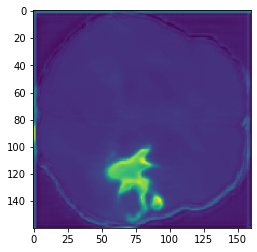

In [163]:
plt.imshow(cv2.resize(pred[slice, 1, :, :].detach().cpu().numpy(), (160, 160), interpolation = cv2.INTER_NEAREST))


In [164]:
pred_seg = torch.sigmoid(pred)
segs = pred_seg.permute(1, 0, 2, 3).detach().cpu().numpy() > 0.52   #4, 144, 144, 144 now i.e c, d, h, w

In [165]:
pred[0, :, 0, 8]

tensor([0.9526, 0.0932, 0.0505, 0.0461], grad_fn=<SelectBackward>)

In [166]:
pred_seg[0, :, 0, 8]

tensor([0.7216, 0.5233, 0.5126, 0.5115], grad_fn=<SelectBackward>)

In [167]:
#On predictions- get Regions
et = segs[1]
net = np.logical_and(segs[2], np.logical_not(et))
ed = np.logical_and(segs[3], np.logical_not(segs[2]))

labelmap = np.zeros(segs[1].shape)
labelmap[et] = 3
labelmap[net] = 1
labelmap[ed] = 2

print(f"voxel values : {np.unique(labelmap)}")

voxel values : [0. 1. 2. 3.]


pixel values: [0. 1. 3.]


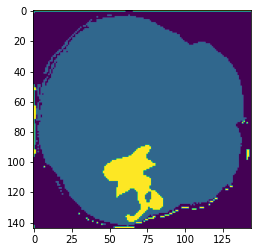

In [168]:
#visualize any 2d slice

plt.imshow(labelmap[slice])
print(f"pixel values: {np.unique(labelmap[slice])}")

In [169]:
ref_seg = p_seg_image.squeeze()
refmap_et, refmap_tc, refmap_wt = [np.zeros_like(ref_seg) for i in range(3)]
refmap_et = ref_seg == 3
refmap_tc = np.logical_or(refmap_et, ref_seg == 1)
refmap_wt = np.logical_or(refmap_tc, ref_seg == 2)
refmap = np.stack([refmap_et, refmap_tc, refmap_wt])

In [170]:
patient_metric_list = calculate_metrics(segs[1:], refmap, 'test')

{   'dice': 0.007601672367920942,
    'haussdorf': 146.27371602581238,
    'label': 'ET',
    'patient_id': 'test',
    'sens': 0.35485460818137016,
    'spec': 0.8120575979639565,
    'tta': False}
{   'dice': 0.018045692039750025,
    'haussdorf': 129.50289572052048,
    'label': 'TC',
    'patient_id': 'test',
    'sens': 0.8851101463257759,
    'spec': 0.5975586051132217,
    'tta': False}
{   'dice': 0.03205091758001023,
    'haussdorf': 119.43198901466893,
    'label': 'WT',
    'patient_id': 'test',
    'sens': 0.11629572097764618,
    'spec': 0.8257321473958718,
    'tta': False}


(4, 144, 144)
torch.Size([144, 144])
[0.0000000e+00 1.2664166e-14 2.5328332e-14 3.7992497e-14 5.0656663e-14
 6.3320829e-14 7.5984995e-14 1.0000000e+00 2.0000000e+00 3.0000000e+00]


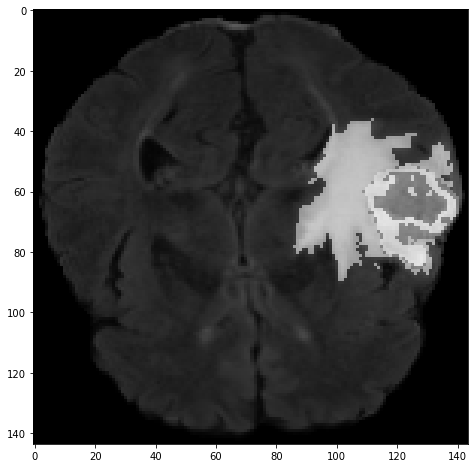

In [171]:
#Overlay with Ground seg



img = p_image[slice, :, :, :].squeeze()
img = utils.make_grid(img)
img = img.detach().cpu().numpy()
print(img.shape)
# plot images
plt.figure(figsize=(10, 8))
img_list = [img[i].T for i in range(channels)] # 1 image per channel
plt.imshow(np.hstack(img_list), cmap='Greys_r')


## plot segmentation mask ##
seg_img = p_seg_image[slice, :, :, :].squeeze()
print(seg_img.shape)
seg_img = torch.tensor(seg_img.numpy()[:, ::-1].copy()) #flip
seg_img = utils.make_grid(seg_img).detach().cpu().numpy()

print(np.unique(p_seg_image))
#seg_img = seg_img > 1
plt.imshow(np.hstack([seg_img[0].T]), cmap='Greys_r', alpha=0.5)
plt.show()

(4, 144, 144)
[0. 1. 3.]


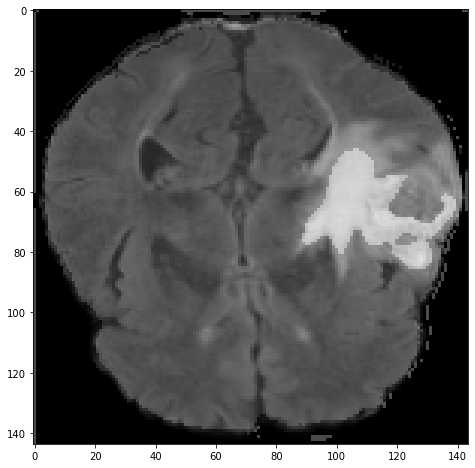

In [172]:
#Overlay with Predicted
img = p_image[slice, :, :, :].squeeze()
img = utils.make_grid(img)
img = img.detach().cpu().numpy()
print(img.shape)
# plot images
plt.figure(figsize=(10, 8))
img_list = [img[i].T for i in range(channels)] # 1 image per channel
plt.imshow(np.hstack(img_list), cmap='Greys_r')
## plot segmentation mask ##
seg_img = torch.tensor(labelmap[slice, :, :].squeeze())
seg_img = utils.make_grid(seg_img).detach().cpu().numpy()
print(np.unique(seg_img))

#plt.figure(figsize=(4, 4))
plt.imshow(np.hstack([seg_img[0].T]), cmap='Greys_r', alpha=0.3)
plt.show()